## Noisy RGB pixels, Conv + UNet + Residual + Conv + Residual, 1/8 U-Net bottleneck, L1 + L2 + Perceptual + Adversarial Loss

In [1]:
import torch
import torch.nn.functional as F
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [2]:
import oidn.wrapper
import importlib
importlib.reload(oidn.wrapper)
oidn_model = oidn.wrapper.load_model()


def plot_frame(frame):
    if frame.shape[0] == 1:
        frame = np.repeat(frame, 3, 0)
    frame = np.clip(frame, 0.0, 1.0)
    frame = np.einsum('kij->ijk', np.flip(frame, axis=1))
    plt.figure()
    plt.imshow(frame)
    plt.show()


def load_data_file(filename, verbose=False):
    data = np.fromfile('data/'+filename, dtype=np.float32)
    n, w, h = map(int, filename[filename.find('_')+1:filename.find('.')].split('_'))
    mat = data[:16].reshape((4, 4))
    # mat = np.linalg.inv(mat).T
    data = data[16:].reshape((n, 3, w, h))
    data = data[3:]
    n = n - 3
    ref = np.zeros((3, w, h), dtype=np.float32)
    weights = np.zeros((3, w, h), dtype=np.float32)
    for i in range(n):
        frame = data[i]
        dw = ((frame > 0.0) & (frame < 1e4)).astype(np.float32) * 2**i
        ref += np.nan_to_num(frame, nan=0.0, posinf=0.0, neginf=0.0) * dw
        weights += dw
        if (n-i) % 4 == 1 and verbose:
            print(2**i, 'spp')
            plot_frame(frame**(1.0/2.2))
    ref /= np.fmax(weights, 1)
    with torch.no_grad():
        x = ref.reshape((1, *ref.shape))
        x = np.fmax(x, 0.0) ** (1.0/2.2)
        # x = np.clip(x, 0.0, 1.0)
        x = torch.tensor(x).to(device)
        y = oidn_model(x)
        ref = np.fmax(y[0].cpu().numpy(), 0.0) ** 2.2
    if verbose:
        print("converged")
        plot_frame(ref**(1.0/2.2))
    return {
        'w': w,
        'h': h,
        'data': data,
        'ref': ref
    }


torch.Size([8, 3, 256, 256])


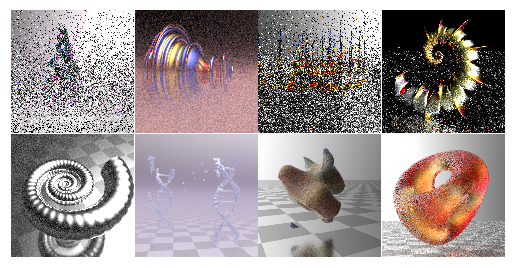

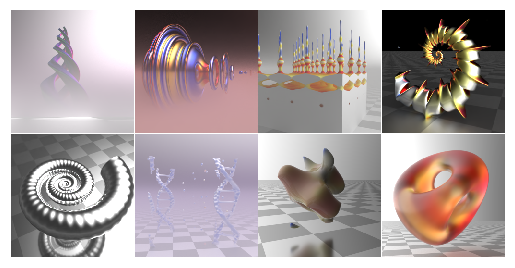

In [3]:
class RawDataset(torch.utils.data.Dataset):
    def __init__(self, n):
        import os
        self.data = [load_data_file(filename) for filename in os.listdir("data/")]
        s = 256
        self.n = n
        self.s = s
        self.coords = []
        for i in range(n):
            k = np.random.randint(0, len(self.data))
            x = np.random.randint(0, self.data[k]['w']-s+1)
            y = np.random.randint(0, self.data[k]['h']-s+1)
            self.coords.append((k, x, y))

    def __len__(self):
        return self.n

    def __getitem__(self, i):
        k, x, y = self.coords[i]
        s = self.s
        n = self.data[k]['data'].shape[0]
        total = np.zeros((3, s, s), dtype=np.float32)
        weights = np.zeros((3, s, s), dtype=np.float32)
        spp = max(round(0.6 * np.random.random()**4 * 2**n), 1)
        for _ in range(n):
            if (spp >> _) & 1 == 0:
                continue
            frame = self.data[k]['data'][_, :, x:x+s, y:y+s]
            dw = ((frame > 0.0) & (frame < 1e4)).astype(np.float32) * 2**_
            total += np.nan_to_num(frame, nan=0.0, posinf=0.0, neginf=0.0) * dw
            weights += dw
        return [
            np.fmax(total / np.fmax(weights, 1), 0.0) ** (1.0/2.2),
            np.fmax(self.data[k]['ref'][:, x:x+s, y:y+s], 0.0) ** (1.0/2.2)
        ]


def plot_imgs(x):
    plt.figure()
    x = torch.clip(x, 0.0, 1.0)
    x = torch.flip(x, [2])
    plt.imshow(np.transpose(vutils.make_grid(x[:8].cpu(),
        nrow=4, padding=2, pad_value=1, normalize=True), (1, 2, 0)),
                interpolation='nearest')
    plt.axis("off")
    plt.show()

for x, y in torch.utils.data.DataLoader(
    RawDataset(128),
    batch_size=8,
    shuffle=True
):
    break

print(x.shape)
plot_imgs(x)
plot_imgs(y)

In [4]:
def conv3(nin, nout):
    return torch.nn.Conv2d(nin, nout, 3, padding=1, bias=True)

def conv1(nin, nout):
    return torch.nn.Conv2d(nin, nout, 1, padding=0, bias=True)

def dconv4(nin, nout):
    return torch.nn.ConvTranspose2d(nin, nout, 4, 2, 1, bias=True)

def relu(x):
    return F.relu(x, inplace=False)

def pool(x):
    return F.max_pool2d(x, 2)

def concat(a, b):
    return torch.concat((a, b), axis=1)

class Model(torch.nn.Module):
    def __init__(self):
        super().__init__()
        n0 = 12
        n1 = 16
        n2 = 24
        n3 = 32
        self.convi = conv3(3, n0)
        self.econv0a = conv3(n0, n0) # 1
        self.econv0b = conv3(n0, n0) # 1
        self.econv1a = conv3(n0, n1) # 1/2
        self.econv1b = conv3(n1, n1) # 1/2
        self.econv2a = conv3(n1, n2) # 1/4
        self.econv2b = conv3(n2, n2) # 1/4
        self.econv3a = conv3(n2, n3) # 1/8
        self.econv3b = conv3(n3, n3) # 1/8
        self.dconv2a = dconv4(n3, n2) # 1/8->1/4
        self.dconv2b = conv1(n2+n2, n2) # 1/4
        self.dconv1a = dconv4(n2, n1) # 1/4->1/2
        self.dconv1b = conv1(n1+n1, n1) # 1/2
        self.dconv0a = dconv4(n1, n0) # 1/2->1
        self.dconv0b = conv1(n0+n0, n0) # 1
        self.convo = conv3(n0, 3)

    def forward(self, input):
        ci = self.convi(input)
        e0 = self.econv0b(relu(self.econv0a(relu(ci)))) # 1
        e1 = self.econv1b(relu(self.econv1a(pool(e0)))) # 1/2
        e2 = self.econv2b(relu(self.econv2a(pool(e1)))) # 1/4
        e3 = self.econv3b(relu(self.econv3a(pool(e2)))) # 1/8
        d2 = relu(self.dconv2a(relu(e3))) # 1/4
        d2 = relu(self.dconv2b(concat(d2, e2))) # 1/4
        d1 = relu(self.dconv1a(d2)) # 1/2
        d1 = relu(self.dconv1b(concat(d1, e1))) # 1/2
        d0 = relu(self.dconv0a(d1)) # 1
        do = relu(self.dconv0b(concat(d0, e0))) # 1
        return self.convo(ci+do) + input


model = Model().to(device)
print(model)

Model(
  (convi): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (econv0a): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (econv0b): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (econv1a): Conv2d(12, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (econv1b): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (econv2a): Conv2d(16, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (econv2b): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (econv3a): Conv2d(24, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (econv3b): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dconv2a): ConvTranspose2d(32, 24, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (dconv2b): Conv2d(48, 24, kernel_size=(1, 1), stride=(1, 1))
  (dconv1a): ConvTranspose2d(24, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (dconv1b): Conv2d(32, 16, kernel_size=(1, 1)

In [5]:
"""Image Denoising Using A Generative Adversarial Network,
    Code modified from implementation by Jeffrey Ming Han Li"""

def mask_non_finite(x, v):
    nan_mask = torch.isnan(x)
    inf_mask = torch.isinf(x)
    x[nan_mask] = v
    x[inf_mask] = v
    return x

class Discriminator(torch.nn.Module):
    def __init__(self,K2):
        super(Discriminator, self).__init__()

        # Basic convolutional block
        def conv_block(in_channels, out_channels, kernel_size, stride):
            return torch.nn.Sequential(
                torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding=1),
                torch.nn.BatchNorm2d(out_channels),
                torch.nn.LeakyReLU(0.01, inplace=True)
            )
        def last_block(in_channels, out_channels, kernel_size, stride):
            return torch.nn.Sequential(
                torch.nn.Conv2d(in_channels,out_channels,kernel_size,stride,1),
                torch.nn.BatchNorm2d(out_channels),
                torch.nn.Sigmoid()
            )

        self.model = torch.nn.Sequential(
            conv_block(3,K2, kernel_size=4, stride=2),
            conv_block(K2,3*K2//2, kernel_size=4, stride=2),
            conv_block(3*K2//2,K2*2, kernel_size=4, stride=2),
            conv_block(K2*2,K2*3, kernel_size=4, stride=2),
            conv_block(K2*3,K2*4, kernel_size=4, stride=2),
            conv_block(K2*4,K2*4, kernel_size=3, stride=1),
            last_block(K2*4,1, kernel_size=3, stride=1)
        )

    def forward(self, x):
        y = self.model(x)
        # print(y.shape)
        y = torch.mean(y, axis=(2, 3))
        y = mask_non_finite(y, 0.5)
        return torch.clip(y, 0.0, 1.0)


class CombinedLoss(torch.nn.Module):
    def __init__(self, lambda_a, lambda_p, lambda_f, lambda_s):
        super(CombinedLoss, self).__init__()
        self.lambda_a = lambda_a
        self.lambda_p = lambda_p
        self.lambda_f = lambda_f
        self.lambda_s = lambda_s

        import torchvision.models
        vgg16 = torchvision.models.vgg16(weights='VGG16_Weights.DEFAULT')
        self.feature_extractor = vgg16.features[:4].to(device)
        print(self.feature_extractor)
        for param in self.feature_extractor.parameters():
            param.requires_grad = False
        self.feature_extractor_2 = vgg16.features[4:9].to(device)
        print(self.feature_extractor_2)
        for param in self.feature_extractor_2.parameters():
            param.requires_grad = False
        self.vgg_mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1).to(device)
        self.vgg_std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1).to(device)
    
    def feature_extractor_1(self, x):
        x = (x - self.vgg_mean) / self.vgg_std
        return self.feature_extractor(x)

    def forward(self, generated, target, discriminator_output, is_discriminator=False):
        # Adversarial Loss
        if is_discriminator:
            return F.binary_cross_entropy(discriminator_output, target)
        loss_a = -torch.mean(discriminator_output)

        # Pixel Loss (Euclidean Distance, L1+L2 Loss)
        loss_p2 = torch.mean((generated-target)**2) / 0.05
        loss_p1 = torch.mean(torch.abs(generated-target))
        loss_p = 0.5*(loss_p1+loss_p2)

        # Feature Loss (Euclidean Distance, L1+L2 Loss)
        gen_features = self.feature_extractor_1(generated)
        target_features = self.feature_extractor_1(target)
        loss_f2 = torch.mean((gen_features-target_features)**2) / 0.25
        loss_f1 = torch.mean(torch.abs(gen_features-target_features))
        gen_features_2 = self.feature_extractor_2(gen_features)
        target_features_2 = self.feature_extractor_2(target_features)
        loss_f2_2 = torch.mean((gen_features_2-target_features_2)**2) / 0.25
        loss_f1_2 = torch.mean(torch.abs(gen_features_2-target_features_2))
        loss_f = 0.25*(loss_f1+loss_f2+loss_f1_2+loss_f2_2)

        # Smooth Loss (Total Variation Loss)
        gen_s = (generated[:,:,:-1,:-1] - generated[:,:,1:,1:])**2 + \
                (generated[:,:,:-1,1:] - generated[:,:,1:,:-1])**2
        target_s = (target[:,:,:-1,:-1] - target[:,:,1:,1:])**2 + \
                (target[:,:,:-1,1:] - target[:,:,1:,:-1])**2
        loss_s = F.mse_loss(torch.sqrt(gen_s), torch.sqrt(target_s)) / 0.05

        # Composite Loss
        total_loss = self.lambda_a * loss_a + self.lambda_p * loss_p + \
                        self.lambda_f * loss_f + self.lambda_s * loss_s

        return total_loss


discriminator = Discriminator(16).to(device)
print(discriminator)

Discriminator(
  (model): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(16, 24, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01, inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(24, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01, inplace=True)
    )
    (3): Sequential(
      (0): Conv2d(32, 48, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
)
Sequential(
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
)
64 g 1.067110300064087 d 1.3268343210220337
128 g 1.2174824476242065 d 1.2879321575164795
192 g 1.6593031883239746 d 1.2711052894592285
256 g 2.1917002201080322 d 1.265702247619629
320 g 2.2564902305603027 d 1.2501341104507446
384 g 1.3553074598312378 d 1.2441009283065796
448 g 0.979536771774292 d 1.2374478578567505
512 g 0.9023343324661255 d 1.2330906391143799
576 g 0.77890545129776 d 1.232814908027649
640 g 1.0063008069992065 d 1.2067315578460693
704 g 0.42536354064941406 d 1.232743024

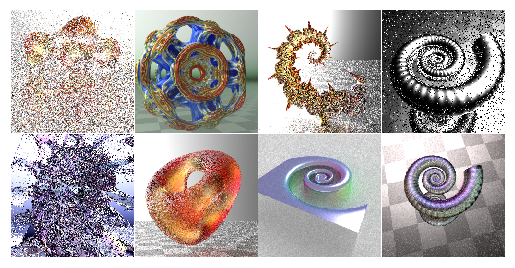

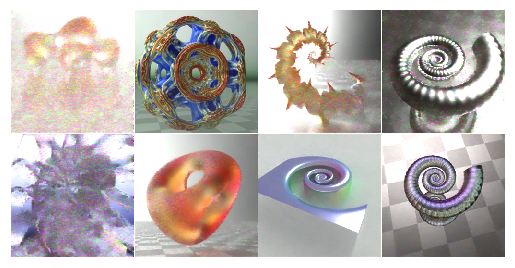

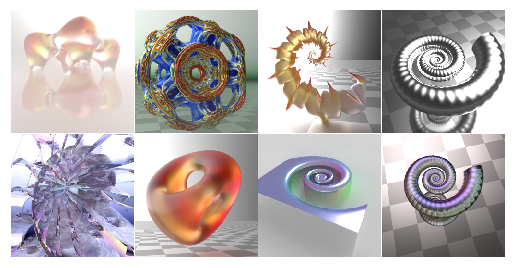

2112 g 0.6392801403999329 d 1.0249462127685547
2176 g 0.5485066771507263 d 1.0111451148986816
2240 g 0.9958817958831787 d 1.0119566917419434
2304 g 0.6238810420036316 d 0.9902334809303284
2368 g 0.73405921459198 d 0.9845679998397827
2432 g 0.580241322517395 d 0.9752590656280518
2496 g 0.6268607974052429 d 0.9710728526115417
2560 g 0.30295270681381226 d 0.9713361263275146
2624 g 0.8237972855567932 d 0.9886450171470642
2688 g 0.6729779243469238 d 0.9509011507034302
2752 g 0.25875335931777954 d 0.9542604684829712
2816 g 0.426632285118103 d 0.9416980743408203
2880 g 0.8770588040351868 d 0.962943971157074
2944 g 0.5392477512359619 d 0.9203563928604126
3008 g 0.4834015369415283 d 0.9463629126548767
3072 g 0.594396710395813 d 0.9099631309509277
3136 g 0.6020387411117554 d 0.9090352654457092
3200 g 0.4804820418357849 d 0.9003851413726807
3264 g 0.6152456998825073 d 0.8897742033004761
3328 g 0.5150676369667053 d 0.9004546403884888
3392 g 0.6737533211708069 d 0.8767063617706299
3456 g 0.68508410

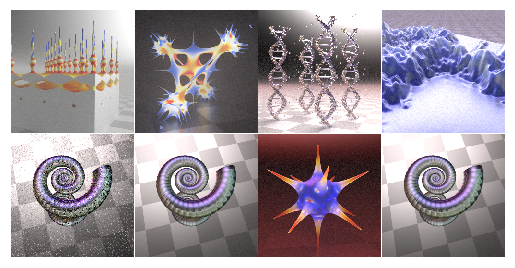

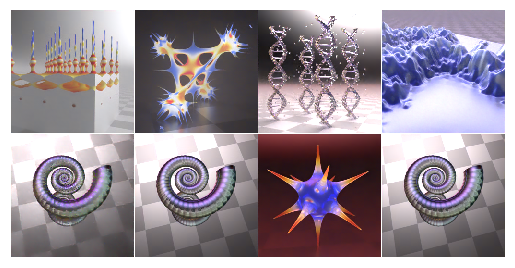

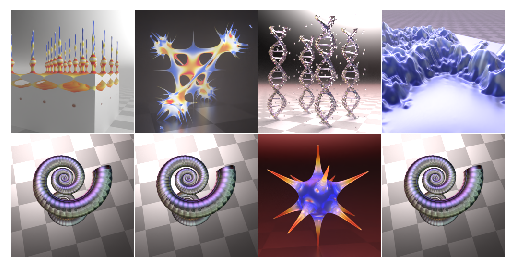

4160 g 0.5116966366767883 d 0.9224504828453064
4224 g 0.5554190874099731 d 1.0764882564544678
4288 g 0.3298848569393158 d 0.9874919652938843
4352 g 0.7737002372741699 d 0.8292206525802612
4416 g 0.7459423542022705 d 0.8281986713409424
4480 g 0.6124024391174316 d 0.8113885521888733
4544 g 0.37595218420028687 d 0.8070735931396484
4608 g 0.38808614015579224 d 0.8127007484436035
4672 g 0.07084353268146515 d 1.2326364517211914
4736 g 0.5117729902267456 d 0.8246829509735107
4800 g 0.8116217255592346 d 0.7787063121795654
4864 g 0.25464940071105957 d 0.7763500809669495
4928 g 0.4018332362174988 d 0.7795796394348145
4992 g 0.4322797358036041 d 0.7709909081459045
5056 g 0.24682162702083588 d 0.7751951217651367
5120 g 0.5302475690841675 d 1.3376023769378662
5184 g 0.712104320526123 d 0.7592435479164124
5248 g 0.6469264030456543 d 0.7576836943626404
5312 g 0.6740640997886658 d 0.7502388954162598
5376 g 0.3287127614021301 d 0.7456256151199341
5440 g 0.3958785831928253 d 0.7315304279327393
5504 g 0.

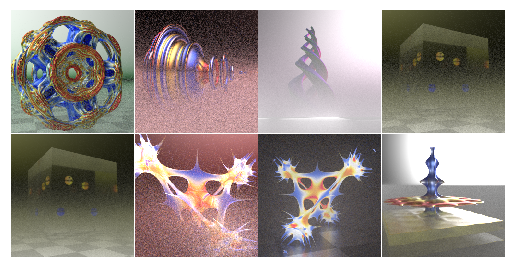

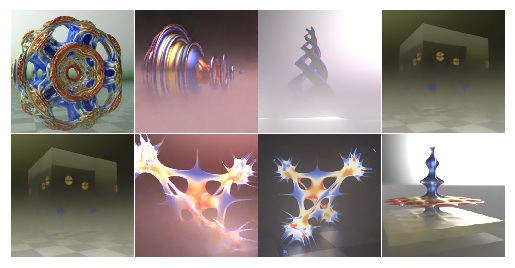

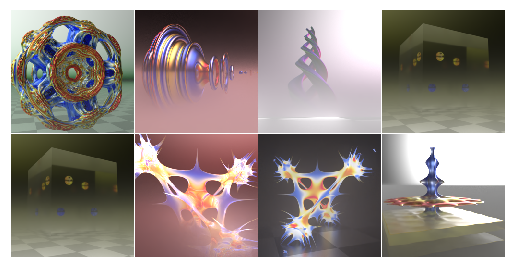

6208 g 0.3160877823829651 d 0.6849592924118042
6272 g 0.940859317779541 d 0.6800243258476257
6336 g 0.5498939156532288 d 0.6810814738273621
6400 g 0.5080008506774902 d 0.6729286909103394
6464 g 0.5428274869918823 d 0.669378936290741
6528 g 0.8589833974838257 d 0.6637427806854248
6592 g 0.5153076648712158 d 0.662882924079895
6656 g 0.1500629335641861 d 0.6736384630203247
6720 g 0.5641604661941528 d 0.6616026163101196
6784 g 0.8293434381484985 d 0.6546547412872314
6848 g 0.2393438071012497 d 0.6520113348960876
6912 g 0.2801281213760376 d 0.6512764096260071
6976 g 0.2549305558204651 d 0.6501389145851135
7040 g 0.6062867641448975 d 0.6402431726455688
7104 g 0.27972522377967834 d 0.6409711241722107
7168 g 0.376192569732666 d 0.6341585516929626
7232 g 0.2788151502609253 d 0.6377692222595215
7296 g 0.3569589853286743 d 0.6281325221061707
7360 g 0.21940231323242188 d 0.6324303150177002
Epoch 00051: reducing learning rate of group 0 to 1.0000e-05.
7424 g 0.7573443651199341 d 0.622451901435852
7

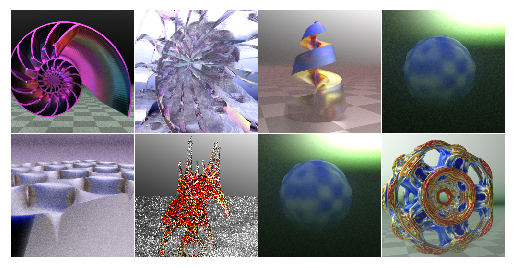

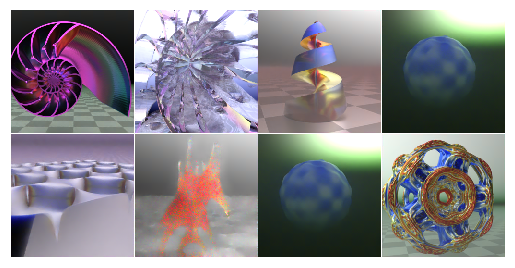

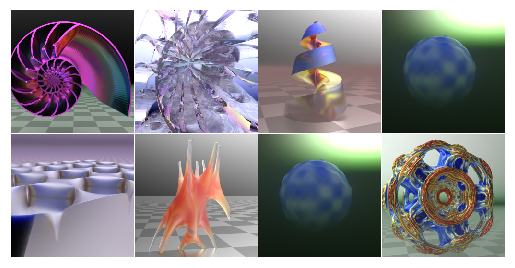

8256 g 0.5397006869316101 d 0.6360965967178345
8320 g 0.3602049946784973 d 0.5926424264907837
8384 g 0.6493297219276428 d 0.5864697694778442
8448 g 0.6487507820129395 d 0.5797863006591797
8512 g 0.2885684072971344 d 0.5807292461395264
8576 g 0.6278933882713318 d 0.5785828828811646
8640 g 0.6256888508796692 d 0.5727822780609131
8704 g 0.30445829033851624 d 0.5970765352249146
Epoch 00072: reducing learning rate of group 0 to 1.0000e-06.
8768 g 0.7127097845077515 d 0.5643209218978882
8832 g 0.38149869441986084 d 0.5632946491241455
8896 g 0.6759629249572754 d 0.5612974166870117
8960 g 0.6347382664680481 d 0.5732517242431641
9024 g 0.8237587213516235 d 0.5749332904815674
9088 g 0.21560893952846527 d 0.5538778305053711
9152 g 0.46514973044395447 d 0.5516539812088013
9216 g 0.3889831304550171 d 0.5472694039344788
9280 g 0.5628184080123901 d 0.5669893026351929
9344 g 0.4454701244831085 d 0.5593665838241577
9408 g 0.5252301096916199 d 0.5472908020019531
9472 g 0.4902574419975281 d 0.53687310218

In [6]:
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=0.001
)
from torch.optim import lr_scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.1, patience=20, min_lr=0.0, verbose=True)

optimizer_d = torch.optim.Adam(
    discriminator.parameters(),
    lr = 0.0005
)

# model 5: 0.2 GAN, 0.2 perceptual, 1.0 no drift
# model 6: 0.5 GAN, 0.2 perceptual, 1.0 no drift
# model 7: model 6 without gamma transform for no drift loss
# model 8: 1.0 GAN, 0.2 perceptual, 1.0 no drift
# model 9: 0.5 GAN, 0.5 perceptual, 1.0 no drift
# model 10: model 6 with lr=(0.0005,0.0005) instead of (0.001,0.0002)
# model 11: model 6 with lr=(0.001,0.0005) instead of (0.001,0.0002)
lossfun = CombinedLoss(0.5, 0.2, 1.0, 0.0)

discriminator_params = torch.cat([x.view(-1) for x in discriminator.parameters()])

batch_size = 16
batch_count = 0
terminate = False
for epoch in range(2):
    trainloader = torch.utils.data.DataLoader(
        RawDataset(2**17), batch_size=batch_size, shuffle=True)
    for x, y in trainloader:
        x = x.to(device)
        y = y.to(device)
        x = torch.log(1+x)
        y = torch.log(1+y)

        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # Update Discriminator
        optimizer_d.zero_grad()
        real_outputs = discriminator(y)
        d_loss_real = lossfun(None, real_labels, real_outputs, is_discriminator=True)

        fake_images = model(x)
        fake_outputs = discriminator(fake_images.detach())
        d_loss_fake = lossfun(None, fake_labels, fake_outputs, is_discriminator=True)

        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        regl2 = 1.0 * torch.mean((discriminator_params)**2)
        regl2.backward()
        optimizer_d.step()

        # Update Generator
        optimizer.zero_grad()
        fake_outputs = discriminator(fake_images)
        g_loss = lossfun(fake_images, y, fake_outputs)
        no_drift_loss = 1.0 * torch.mean(mask_non_finite(
            torch.log(torch.mean(
                torch.clip(torch.exp(fake_images)-1.0,0.0,1e3)**2.2 - \
                torch.clip(torch.exp(y)-1.0,0.0,1e3)**2.2,
                axis=(2, 3))**2+1.0),
            0.0)) / 0.05
        # no_drift_loss = 1.0 * torch.mean(mask_non_finite(
        #     torch.mean(fake_images-y, axis=(2, 3))**2,
        #     0.0)) / 0.05
        (g_loss+no_drift_loss).backward()
        optimizer.step()

        batch_count += 1
        if batch_count % 64 == 0:
            print(batch_count, 'g', g_loss.item(), 'd', d_loss.item())
            if batch_count > 4096:
                scheduler.step(g_loss)
            if optimizer.param_groups[0]['lr'] < 1e-6:
                terminate = True
                break
        if batch_count % 2048 == 0:
            plot_imgs(torch.exp(x)-1)
            plot_imgs(torch.exp(fake_images.detach())-1)
            plot_imgs(torch.exp(y)-1)
            model_path = "model6.pth"
            torch.save(model, model_path)
    if terminate:
        break

torch.save(model, model_path)
